In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from numpy import mean

from analysis import *
from joblib import Parallel, delayed

base_dir = '/Users/dhruvlaad/IIT/DDP/data/'
# base_dir = 'D:/IIT/DDP/data/'
label_info_file = base_dir + 'analysis/label_info.pkl'
stats_file = base_dir + 'analysis/stats.pkl'

In [2]:
behaviour_stats = all_behaviour_info_for_all_strains(label_info_file, max_label=19)

for key in BEHAVIOUR_LABELS.keys():
    nb_max = max(behaviour_stats[key]['No. of Bouts'])
    print(f'{key}: {nb_max}')
    
# with open(stats_file, 'rb') as f:
#     behaviour_stats = joblib.load(f)

Groom: 243
Run: 1988
Walk: 1291
CW-Turn: 843
CCW-Turn: 727
Point: 3131
Rear: 3222
N/A: 5171


In [33]:
# behaviour_stats.keys()
key = 'Point'
plot_dir = base_dir + 'analysis/plots'
stats = behaviour_stats[key]
info = pd.DataFrame.from_dict(stats)

In [34]:
info_ = info.copy(deep=True)
info_['Total Duration'] = info['Total Duration']/60
info_['Average Bout Length'] = info['Average Bout Length']

# plotting routines

In [6]:
def sort_info_df(info, metric):
    N = info.shape[0]
    strains = {}
    for strain in info['Strain']:
        strains[strain] = []
        
    for i in range(N):
        data = info.iloc[i]
        strains[data['Strain']].append(data[metric])
    
    for key, value in strains.items():
        strains[key] = sum(value)/len(value)
    
    strains = dict(sorted(strains.items(), key=lambda item: item[1]))
    return strains.keys()

def plot_behaviour_metric(info, metric, order, ylabel=None):        
    ylabel = metric if ylabel is None else ylabel
    
    fig = plt.figure(figsize=(10, 100))
    g = sns.catplot(x='Strain', y=metric, data=info, hue='Sex', jitter=False, legend=False, order=order, ci=0.95)
    ax = g.axes[0,0]
    ax.tick_params(grid_color='gray', grid_alpha=0.3, labelrotation=90, labelsize=8)
    ax.grid(True)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(None, fontsize=12)
    ax.legend(loc='upper left')
    plt.gcf().set_size_inches(15, 2.2)
    return fig, ax

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

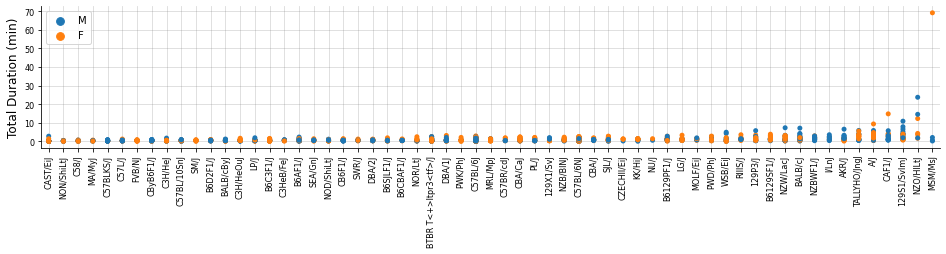

In [36]:
strains = list(sort_info_df(info_, 'Total Duration'))
fig, ax = plot_behaviour_metric(info_, 'Total Duration', strains, 'Total Duration (min)', )
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

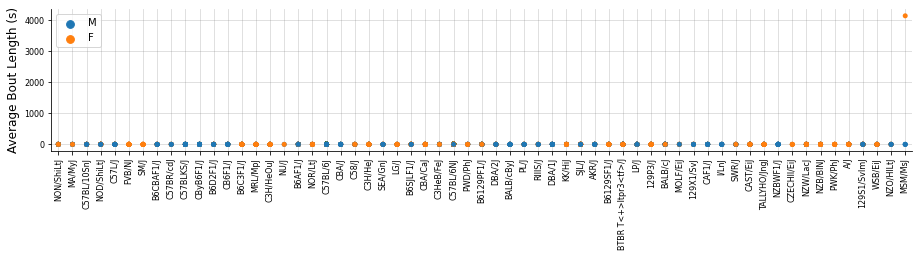

In [39]:
strains = list(sort_info_df(info_, 'Average Bout Length'))
fig, ax = plot_behaviour_metric(info_, 'Average Bout Length', strains, 'Average Bout Length (s)', )
# ax.set_ylim([MIN_BOUT_LENS[key]/1000, 2])
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

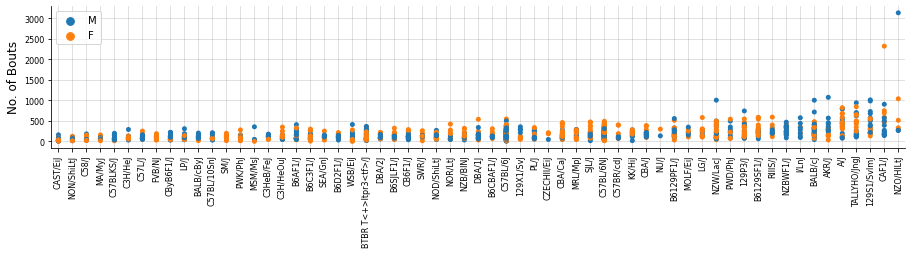

In [38]:
strains = list(sort_info_df(info_, 'No. of Bouts'))
fig, ax = plot_behaviour_metric(info_, 'No. of Bouts', strains, 'No. of Bouts', )
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

In [ ]:
# plot behaviour distribution for all data
import numpy as np
from analysis import *
from BSOID.bsoid import BSOID

prop = 100 * calculate_behaviour_usage(label_info_file, max_label=19)

labels = [None for _ in range(len(prop))]
for key, val in BEHAVIOUR_LABELS.items():
    if len(val) > 1:
        for i, idx in enumerate(val):
            labels[idx] = f'{key} #{i}'
    else:
        labels[val[0]] = key
fig = plt.figure(figsize=(12,9))
ax = sns.barplot(x=np.arange(len(prop)), y=prop)
ax.set_xticklabels(labels)
ax.set_ylabel('% samples of behaviour')
ax.tick_params(axis='x', labelrotation=90, labelsize=12)
fig.savefig(f'{plot_dir}/prop.png')
fig.show()

# Show proportion of behaviour used for each strain
----

In [ ]:
usage_data = behaviour_usage_across_strains(stats_file, min_threshold=0.01)
usage_data = usage_data.pivot_table(index='Behaviour', columns='Strain', values='Usage')

ax = sns.heatmap(usage_data, xticklabels=True, yticklabels=True, cmap='cubehelix')
plt.gcf().set_size_inches(15.5, 4)
plt.savefig(f'{plot_dir}/usage.png')
plt.show() 

# Plot transition network

In [86]:
def tnet_from_tmat(tmat, behaviour_usage, n_edges):        
    bins = [0, 0.01, 0.05, 0.2]

    for i in range(tmat.shape[0]):
        tmat[i,i] = -1

    G = nx.MultiDiGraph()
    G.add_nodes_from(range(0, tmat.shape[0]))

    for i in range(tmat.shape[0]):
        for j in range(tmat.shape[1]):
            if i != j:
                bin_idx = bin_wts(tmat[i,j], bins)
                if bin_idx > 0:
                    G.add_edge(i, j, weight=tmat[i,j])

    edge_wts = [0.5, 1, 5]
    widths = [edge_wts[bin_wts(G[u][v][0]['weight'], bins) - 1] for u, v in G.edges()]
    return G, widths

def bin_wts(wt, bins):
    for i in range(len(bins)-1):
        if wt >= bins[i] and wt < bins[i+1]:
            return i
    return len(bins) - 1

def get_usage_for_strain(label_info_file, strain=None, max_label=None):
    with open(label_info_file, 'rb') as f:
        label_info = joblib.load(f)
    N = len(label_info['Strain'])
    
    if strain is not None:
        labels = [label_info['Labels'][i] for i in range(N) if label_info['Strain'][i] == strain]
    else:
        labels = label_info['Labels']
    del label_info
    
    usage_data = Parallel(n_jobs=-1)(delayed(behaviour_proportion)(labs, max_label) for labs in labels)
#     usage_data = np.vstack([behaviour_proportion(labs, max_label) for labs in labels])
    usage_data = np.vstack(usage_data)
    usage_data = usage_data.sum(axis=0)/usage_data.shape[0]
    return usage_data
    
def get_tmat_for_strain(label_info_file, strain=None, max_label=None):
    with open(label_info_file, 'rb') as f:
        label_info = joblib.load(f)
    N = len(label_info['Strain'])
    
    if strain is not None:
        labels = [label_info['Labels'][i] for i in range(N) if label_info['Strain'][i] == strain]
    else:
        labels = label_info['Labels']
    del label_info
    
#     tmat_data = [transition_matrix_from_assay(labs, max_label) for labs in labels]
    tmat_data = Parallel(n_jobs=-1)(delayed(transition_matrix_from_assay)(labs, max_label) for labs in labels)
            
    tmat = tmat_data[0]
    for i in range(1, len(tmat_data)):
        tmat += tmat_data[i]
    
    tmat = tmat / len(tmat_data)
    return tmat

In [7]:
tmat = get_tmat_for_strain(label_info_file, max_label=19)
usage = get_usage_for_strain(label_info_file, max_label=19)

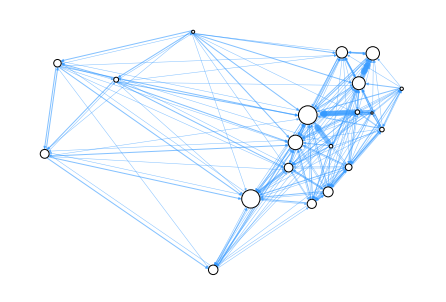

In [89]:
G, widths = tnet_from_tmat(tmat, usage, 3)

color = tuple([ x / 255 for x in [51,153,255,0.6 * 255]])
nx.draw_spectral(G, node_size=2000*usage, connectionstyle='bar, fraction = 0.01', edge_color=color, edgecolors='k', node_color='white', width=widths, arrowsize=5)
plt.show()